
We then extended the model by adding an "exposed" state, i.e. an incubation period of the infectious disease. Here the individual would have the disease but without being able to pass it on before reaching the "infected" state. 
This means that our model now both have a probability of going from "susceptible" to "exposed" and from "infected" to "recovered". Instead of a probability of going from the "exposed" state to the "infected" state for each time step, we draw the time that the individual should stay in the "exposed" state. This was done both as a way of intuitively modeling a more fixed incubation time (i.e. we didn't want a probability that the individual could be in this state for a much shorter/longer time period), and as a way of exploring extensions of the model in another way than adding another state with a given probability. 

The model works as earlier described (i.e. same population size, no one leaves the system etc.), but with the following addition: For all the individuals in the "susceptible" state, we draw the probability that they will go to the "exposed" state. Earlier, we modelled the transistion from the "susceptible" state to the "infected" state with a probability for each time step. We still do this when going from the "susceptible" state to the "exposed" state, as the probability of getting infected (i.e. going to the exposed state, then the infected), should still depend on how many infected individuals we have in the population. In other words, the greater the share of infected individuals, the higher the probability of going into the "exposed" state for the susceptible indivuals. For the individuals that do transition to the "exposed" state, we further draw a time they should stay in this state. This period is drawn from a normal distribution. For each timestep, we update the individuals for who the "exposed" state have reached its end to the "infected" state. After this, we again for each timestep draw the probability of moving to the next state. In this case we have a SEIR model, i.e. the individual will have life long immunity and will thus not be able to return to the "susceptible" state again. 

In this model we consider an incubation time of a more fixed time, i.e. we consider the disease to be one which simply evovles over x days before giving rise to symptoms and becoming contagious (i.e. Gonorrhea has an incubation time of 1 week, HIV of 4 weeks etc.). We achieved this more fixed time by drawing the time from a normal distribution with a small standard deviation (we use a standard deviation of 0.2 days). A more variable incubation time could of course be achieved with the same method, by drawing from a wider distribution. The incubation time could also be modelled as a time period in which the disease is actually contagious, but maybe with a lower probability than in the "infected" stage.

We tested the model with different parameter values. In order to obtain manageable results, we only varied the parameters that deviate from the initial SIR model. The probability of going from the "infected" to the "recovered" state was kept as 0.2, as this gave the biggest disease outbreak in our SIR model. For the probability of entering the "exposed" state from the "susceptible" state, we tested the three parameter values 0.2, 0.5 and 0.8. Furthermore, for each of these we tested three different means for the time individuals should spend in the "exposed" state: 2 days, 5 days and 10 days. For each parameter combination, we computed the maximum number of infected (I_max), which time this occured (t_max) and the time for which the infection ended (t_end). This was run 100 times for each to compute means and 95% confidence intervals. 
The results can be seen below.

In [16]:
# Initialization
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tabulate import tabulate

In [57]:
n = 1000
n_runs = 100

prob_S_E_values = np.array([0.2, 0.5, 0.8])
E_mean_values = np.array([2, 5, 10])

statistics = np.zeros(8)
#statistics = np.array((0.2, 0.2, 1.68, str([1.2 , 2.16]), 3.53, str([0.91, 6.15]), 10.95, str([ 6.4, 15.5])))

# Sets counter
counter = 0

# Sets parameter values
prob_I_R = 0.2

# Runs through parameter values between S and E
for prob_S_E_value in prob_S_E_values:
    prob_S_E = prob_S_E_value 
    
    # Runs through parameter values between I and R
    for mean_value  in E_mean_values:
        # Sets incubation mean to current value
        E_mean = mean_value 
        
        # Initiates vector
        max_values = np.zeros(n_runs)
        max_t_values = np.zeros(n_runs)
        end_of_inf_values = np.zeros(n_runs)
        
        # Runs 100 times to get comparable values
        for i in range(n_runs):
            
            # Vector of states
            states = np.repeat("S",n)
            states[0] = "I"

            n_S = np.array([len(np.where(states == "S")[0])])
            n_E = np.array([len(np.where(states == "E")[0])])
            n_I = np.array([len(np.where(states == "I")[0])])
            n_R = np.array([len(np.where(states == "R")[0])])

            E_times = np.zeros(n)
            E_scale = 1

            while "I" in states:

                # Get positions of S, I, R
                S_index = np.where(states == "S")[0]
                E_index = np.where(states == "E")[0]
                I_index = np.where(states == "I")[0]
                R_index = np.where(states == "R")[0]

                # Update exposed
                E_times[E_index] = E_times[E_index] - 1
                states[np.where((E_times == 0) & (states == "E"))] = "I"

                # Update susceptible
                prob_S_E_t = prob_S_E * len(I_index)/n
                states[S_index] = np.random.choice(np.array(["S", "E"]),p = np.array([1-prob_S_E_t, prob_S_E_t]), size = len(S_index))

                # Assign incubation time for exposed
                E_index_new = np.where((states == "E") & (E_times == 0))
                E_times[E_index_new] = np.round(np.random.normal(loc = E_mean, scale = E_scale))

                # Update infected
                states[I_index] = np.random.choice(np.array(["I", "R"]),p = np.array([1-prob_I_R, prob_I_R]), size = len(I_index))

                # Updates count in each state
                n_S = np.concatenate([n_S, np.array([len(np.where(states == "S")[0])])])
                n_E = np.concatenate([n_E, np.array([len(np.where(states == "E")[0])])])
                n_I = np.concatenate([n_I, np.array([len(np.where(states == "I")[0])])])
                n_R = np.concatenate([n_R, np.array([len(np.where(states == "R")[0])])])
            
            
            # Updates values for statistics for each 100th iteration
            max_values[i] = max(n_I)
            max_t_values[i] = float(np.where(n_I == max(n_I))[0][0])
            end_of_inf_values[i] = len(n_I) 

        # Calculates statistics
        I_max_mean = str(np.mean(max_values))
        I_max_CI = str(np.round(stats.norm.interval(alpha=0.95, loc=np.mean(max_values), scale=stats.sem(max_values)), 2))
        I_max_t_mean = str(np.mean(max_t_values))
        I_max_t_CI = str(np.round(stats.norm.interval(alpha=0.95, loc=np.mean(max_t_values), scale=stats.sem(max_t_values)), 2))
        I_end_of_inf_mean = str(np.mean(end_of_inf_values))
        I_end_of_inf_CI = str(np.round(stats.norm.interval(alpha=0.95, loc=np.mean(end_of_inf_values), scale=stats.sem(end_of_inf_values)), 2))
        
        # Adds to statistics matrix for later table
        new_stats = (prob_S_E, E_mean, I_max_mean, I_max_CI, I_max_t_mean, I_max_t_CI , I_end_of_inf_mean, I_end_of_inf_CI)
        statistics = np.vstack((statistics, new_stats))

        # Updates counter    
        counter += 1

# Print statistics table
print(tabulate(statistics[1:,], headers=["S-->E","Mean E", "I_max mean", "I_max CI", "t_max mean", "t_max CI", "t_end mean", "t_end CI"], tablefmt='orgtbl'))

|   S-->E |   Mean E |   I_max mean | I_max CI        |   t_max mean | t_max CI      |   t_end mean | t_end CI      |
|---------+----------+--------------+-----------------+--------------+---------------+--------------+---------------|
|     0.2 |        2 |         1.76 | [1.42 2.1 ]     |         2.82 | [1.55 4.09]   |         9.17 | [ 6.5  11.84] |
|     0.2 |        5 |         1.32 | [1.08 1.56]     |         1.95 | [0.59 3.31]   |         7.79 | [5.76 9.82]   |
|     0.2 |       10 |         1.06 | [1.01 1.11]     |         0.88 | [0.18 1.58]   |         5.94 | [5.03 6.85]   |
|     0.5 |        2 |        62.62 | [46.09 79.15]   |        16.24 | [12.06 20.42] |        36.77 | [28.19 45.35] |
|     0.5 |        5 |        29.46 | [17.78 41.14]   |        12.3  | [ 7.49 17.11] |        26.78 | [17.7  35.86] |
|     0.5 |       10 |         5.75 | [ 1.21 10.29]   |         3.7  | [0.68 6.72]   |        11.65 | [ 5.88 17.42] |
|     0.8 |        2 |       151.36 | [121.56 181.16] | 

Here it can be seen that we obtain the largest disease outbreak with a high probability (p = 0.8) of going from "susceptible" to "exposed" and the lowest mean time (t = 2 days) for incubation time, as this has the highest value for both the maximum number of infected and the duration of the disease outbreak. Here it can be seen that the confidence interval is quite wide, indicating that it varies quite a lot between simulations. This could be expected, as we can no matter what (as long as we don't have p=1) risk that patient zero recovers before passing it on to other individuals, thus giving great variability between simulations. On the contrary, the lowest probability (p = 0.2) and the highest incubation time (t = 10) result in the smallest disease outbreak. Here the confidence interval is more narrow around 1, indicating that the one infected individual in most cases transitions to recovered before passing on the disease. These epidemic vs. parameter tendencies seem reasonable, as a high probability of becoming exposed (and thereby infected) together with a short period of non-contagiousness (i.e. the incubation time) will result in a larger disease outbreak. 
Below, we have plotted the simulation of the disease outbreaks with the two mentioned parameter combinations.

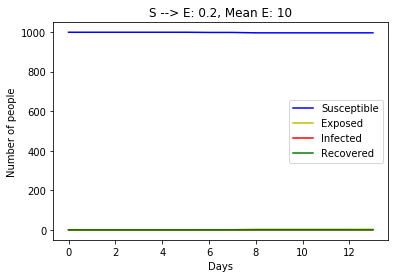

Maximum number of infected:  1


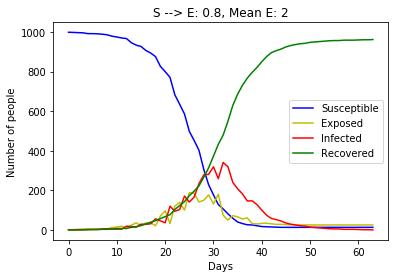

Maximum number of infected:  341


In [52]:
# Runs 2 times to plot largest and smallest epidemic
prob_S_E_values = np.array([0.2, 0.8])
mean_values  = np.array([10, 2])

# Sets parameter values
prob_I_R = 0.2

# For loop to create plots for both
for i in range(2):
    # Sets parameters
    prob_S_E = prob_S_E_values[i]
    E_mean = mean_values[i]
    
    # Vector of states
    states = np.repeat("S",n)
    states[0] = "I"

    n_S = np.array([len(np.where(states == "S")[0])])
    n_E = np.array([len(np.where(states == "E")[0])])
    n_I = np.array([len(np.where(states == "I")[0])])
    n_R = np.array([len(np.where(states == "R")[0])])

    E_times = np.zeros(n)
    E_scale = 1

    while "I" in states:

        # Get positions of S, I, R
        S_index = np.where(states == "S")[0]
        E_index = np.where(states == "E")[0]
        I_index = np.where(states == "I")[0]
        R_index = np.where(states == "R")[0]

        # Update exposed
        E_times[E_index] = E_times[E_index] - 1
        states[np.where((E_times == 0) & (states == "E"))] = "I"

        # Update susceptible
        prob_S_E_t = prob_S_E * len(I_index)/n
        states[S_index] = np.random.choice(np.array(["S", "E"]),p = np.array([1-prob_S_E_t, prob_S_E_t]), size = len(S_index))

        # Assign incubation time for exposed
        E_index_new = np.where((states == "E") & (E_times == 0))
        E_times[E_index_new] = np.round(np.random.normal(loc = E_mean, scale = E_scale))

        # Update infected
        states[I_index] = np.random.choice(np.array(["I", "R"]),p = np.array([1-prob_I_R, prob_I_R]), size = len(I_index))

        # Updates count in each state
        n_S = np.concatenate([n_S, np.array([len(np.where(states == "S")[0])])])
        n_E = np.concatenate([n_E, np.array([len(np.where(states == "E")[0])])])
        n_I = np.concatenate([n_I, np.array([len(np.where(states == "I")[0])])])
        n_R = np.concatenate([n_R, np.array([len(np.where(states == "R")[0])])])


    # Plot
    plt.figure()
    plt.plot(n_S, "-b", label = "Susceptible")
    plt.plot(n_E, "-y", label = "Exposed")
    plt.plot(n_I, "-r", label = "Infected")
    plt.plot(n_R, "-g", label = "Recovered")
    plt.ylabel("Number of people")
    plt.xlabel("Days")
    #plt.xlim(0,100)
    plot_title = "S --> E: " + str(prob_S_E) + ", Mean E: " + str(E_mean)
    plt.title(plot_title)
    plt.legend()
    plt.show()

    print("Maximum number of infected: ", max(n_I))



Here it can be seen that for the "small disease outbreak", this simulation exactly shows that the first infected individual never manages to pass the disease on, as the population remains in the "susceptible" state. For the "large epidemic", we see a standard SIR development with this reversed course in the number of susceptible and recovered. The fluctuations for exposed and infected could indicate a delay that arises when many individuals have entered the exposed state, but will first begin to pass it on around two days later. Thus, the effect of the newly diseased individuals will first be apparent with ~2 days delay.